In [1]:
import imp
import time
import argparse
import numpy as np
import torch
torch.set_printoptions(threshold=10000)
from torch_geometric.datasets import Planetoid,Reddit2,Flickr
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
# from torch_geometric.loader import DataLoader
from help_funcs import prune_unrelated_edge,prune_unrelated_edge_isolated, clu_prune_unrelated_edge
import scipy.sparse as sp
from torch_geometric.utils import subgraph
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--debug', action='store_true',
        default=True, help='debug mode')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--seed', type=int, default=10, help='Random seed.')
parser.add_argument('--model', type=str, default='GCN', help='model',
                    choices=['GCN','GAT','GraphSage','GIN'])
parser.add_argument('--dataset', type=str, default='Cora', 
                    help='Dataset',
                    choices=['Cora','Pubmed','Flickr','ogbn-arxiv','Citeseer','Reddit2'])
parser.add_argument('--train_lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=64,
                    help='Number of hidden units.')
parser.add_argument('--thrd', type=float, default=0.5)
parser.add_argument('--target_class', type=int, default=0)
parser.add_argument('--k', type=int, default=100)
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('--epochs', type=int,  default=1000, help='Number of epochs to train benign and backdoor model.')
parser.add_argument('--rec_epochs', type=int,  default=30, help='Number of epochs to train benign and backdoor model.')
parser.add_argument('--trojan_epochs', type=int,  default=400, help='Number of epochs to train trigger generator.')
parser.add_argument('--inner', type=int,  default=1, help='Number of inner')
# backdoor setting
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--trigger_size', type=int, default=3,
                    help='tirgger_size')
parser.add_argument('--use_vs_number', action='store_true', default=True,
                    help="if use detailed number to decide Vs")
parser.add_argument('--vs_ratio', type=float, default=0,
                    help="ratio of poisoning nodes relative to the full graph")
parser.add_argument('--range', type=float, default=1.0,
                    help="ratio of poisoning nodes relative to the full graph")
parser.add_argument('--vs_number', type=int, default=40,
                    help="number of poisoning nodes relative to the full graph")
# defense setting
parser.add_argument('--defense_mode', type=str, default="none",
                    choices=['prune', 'isolate', 'none','reconstruct'],
                    help="Mode of defense")
parser.add_argument('--prune_thr', type=float, default=0.8,
                    help="Threshold of prunning edges")
parser.add_argument('--target_loss_weight', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_target', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_ood', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_targetclass', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--outter_size', type=int, default=4096,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--homo_loss_weight', type=float, default=100,
                    help="Weight of optimize similarity loss")
parser.add_argument('--homo_boost_thrd', type=float, default=0.8,
                    help="Threshold of increase similarity")
# attack setting
parser.add_argument('--dis_weight', type=float, default=1,
                    help="Weight of cluster distance")
parser.add_argument('--selection_method', type=str, default='none',
                    choices=['loss','conf','cluster','none','cluster_degree'],
                    help='Method to select idx_attach for training trojan model (none means randomly select)')
parser.add_argument('--test_model', type=str, default='GAT',
                    choices=['GCN','GAT','GraphSage','GIN'],
                    help='Model used to attack')
parser.add_argument('--evaluate_mode', type=str, default='1by1',
                    choices=['overall','1by1'],
                    help='Model used to attack')
# GPU setting
parser.add_argument('--device_id', type=int, default=3,
                    help="Threshold of prunning edges")
# args = parser.parse_args()
args = parser.parse_known_args()[0]
args.cuda =  not args.no_cuda and torch.cuda.is_available()
device = torch.device(('cuda:{}' if torch.cuda.is_available() else 'cpu').format(args.device_id))

np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
print(args)

/tmp/ipykernel_1313764/534782185.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/zbz5349/anaconda3/envs/spurious/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Namespace(cuda=True, dataset='Cora', debug=True, defense_mode='none', device_id=3, dis_weight=1, dropout=0.5, epochs=1000, evaluate_mode='1by1', hidden=64, homo_boost_thrd=0.8, homo_loss_weight=100, inner=1, k=100, lr=0.01, model='GCN', no_cuda=False, outter_size=4096, prune_thr=0.8, range=1.0, rec_epochs=30, seed=10, selection_method='none', target_class=0, target_loss_weight=1, test_model='GIN', thrd=0.5, train_lr=0.01, trigger_size=3, trojan_epochs=400, use_vs_number=True, vs_number=40, vs_ratio=0, weight_decay=0.0005, weight_ood=1, weight_target=1, weight_targetclass=1)


In [2]:
from torch_geometric.utils import to_undirected
import torch_geometric.transforms as T
transform = T.Compose([T.NormalizeFeatures()])

if(args.dataset == 'Cora' or args.dataset == 'Citeseer' or args.dataset == 'Pubmed'):
    dataset = Planetoid(root='./data/', \
                        name=args.dataset,\
                        transform=transform)
elif(args.dataset == 'Flickr'):
    dataset = Flickr(root='./data/Flickr/', \
                    transform=transform)
elif(args.dataset == 'Reddit2'):
    dataset = Reddit2(root='./data/Reddit2/', \
                    transform=transform)
elif(args.dataset == 'ogbn-arxiv'):
    from ogb.nodeproppred import PygNodePropPredDataset
    # Download and process data at './dataset/ogbg_molhiv/'
    dataset = PygNodePropPredDataset(name = 'ogbn-arxiv', root='./data/')
    split_idx = dataset.get_idx_split() 

data = dataset[0].to(device)

if(args.dataset == 'ogbn-arxiv'):
    nNode = data.x.shape[0]
    setattr(data,'train_mask',torch.zeros(nNode, dtype=torch.bool).to(device))
    # dataset[0].train_mask = torch.zeros(nEdge, dtype=torch.bool).to(device)
    data.val_mask = torch.zeros(nNode, dtype=torch.bool).to(device)
    data.test_mask = torch.zeros(nNode, dtype=torch.bool).to(device)
    data.y = data.y.squeeze(1)
    
if(args.dataset == 'Reddit2'):
    num_nodes_to_sample = 20000  # Adjust this based on your needs

    # Randomly select a subset of nodes
    sampled_nodes = torch.randint(data.num_nodes, (num_nodes_to_sample,), device=device)

    # Perform subgraph sampling
    edge,_ = subgraph(sampled_nodes, data.edge_index)
    data.edge_index = edge

In [3]:
from utils import get_split
data, idx_train, idx_val, idx_clean_test, idx_atk = get_split(args,data,device)

from torch_geometric.utils import to_undirected
from utils import subgraph
data.edge_index = to_undirected(data.edge_index)
train_edge_index,_, edge_mask = subgraph(torch.bitwise_not(data.test_mask),data.edge_index,relabel_nodes=False)
mask_edge_index = data.edge_index[:,torch.bitwise_not(edge_mask)]

In [4]:
from sklearn_extra import cluster
from models.backdoor import Backdoor
from models.construct import model_construct
import heuristic_selection as hs
from torch.distributions.bernoulli import Bernoulli

# select poisoned target node #

# filter out the unlabeled nodes except from training nodes and testing nodes, nonzero() is to get index, flatten is to get 1-d tensor
unlabeled_idx = (torch.bitwise_not(data.test_mask)&torch.bitwise_not(data.train_mask)).nonzero().flatten()
if(args.use_vs_number):
    size = args.vs_number
else:
    size = int((len(data.test_mask)-data.test_mask.sum())*args.vs_ratio)
# print("#Attach Nodes:{}".format(size))
assert size>0, 'The number of selected trigger nodes must be larger than 0!'
# here is randomly select poison nodes from unlabeled nodes
if(args.selection_method == 'none'):
    idx_attach = hs.obtain_attach_nodes(args,unlabeled_idx,size)
elif(args.selection_method == 'cluster'):
    idx_attach = hs.cluster_distance_selection(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    idx_attach = torch.LongTensor(idx_attach).to(device)
elif(args.selection_method == 'cluster_degree'):
    if(args.dataset == 'Pubmed'):
        idx_attach = hs.cluster_degree_selection_seperate_fixed(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    else:
        idx_attach = hs.cluster_degree_selection(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    idx_attach = torch.LongTensor(idx_attach).to(device)
# print("idx_attach: {}".format(idx_attach))
unlabeled_idx = torch.tensor(list(set(unlabeled_idx.cpu().numpy()) - set(idx_attach.cpu().numpy()))).to(device)
print('number of benign training nodes', len(idx_train))
print('number of poisoned target nodes', len(idx_attach))

# Cora
idx_attach = torch.tensor([2183, 2202,  980, 1291, 2630, 2530,  376,  590, 1220,  574,  276,   15,
        2049, 2117, 2535, 1505, 2665, 1469,  316, 1201,  511,  700, 1259,  357,
        1754,  228, 2290, 1019, 2546,  958, 1263, 2556, 2003,   51,  342,  711,
        2305,  461, 1246, 1850])


idx_attach = idx_attach.to(device)

number of benign training nodes 541
number of poisoned target nodes 40


In [5]:
## trigger generator ##
model = Backdoor(args,device)
model.fit(data.x, train_edge_index, None, data.y, idx_train,idx_attach, unlabeled_idx, True)

0

In [6]:

total_overall_asr = 0
total_overall_ca = 0

rs = np.random.RandomState(args.seed)
seeds = rs.randint(1000,size=1)
overall_asr = 0
overall_ca = 0

In [7]:
# load poisoned graph #
# poison_x = torch.load('poison_x.pt')
# poison_edge_index = torch.load('poison_edge_index.pt')
# poison_edge_weights = torch.load('poison_edge_weights.pt')
# poison_labels = torch.load('poison_labels.pt')
poison_x = torch.load('poison_x_cora.pt').to(device)
poison_edge_index = torch.load('poison_edge_index_cora.pt').to(device)
poison_edge_weights = torch.load('poison_edge_weights_cora.pt').to(device)
poison_labels = torch.load('poison_labels_cora.pt').to(device)

In [8]:
print(args)

mask = data.y[idx_attach] != args.target_class
mask = mask.to(device)

## only attack those has groud truth labels != target_class ##
idx_attach = idx_attach[(data.y[idx_attach] != args.target_class).nonzero().flatten()]

bkd_tn_nodes = torch.cat([idx_train,idx_attach]).to(device)
# test_model = model_construct(args,args.test_model,data,device).to(device) 
known_nodes = torch.cat([idx_train,idx_attach]).to(device)
predictions = []
# edge weight for clean edge_index, may use later #
edge_weight = torch.ones([data.edge_index.shape[1]],device=device,dtype=torch.float)


Namespace(cuda=True, dataset='Cora', debug=True, defense_mode='none', device_id=3, dis_weight=1, dropout=0.5, epochs=1000, evaluate_mode='1by1', hidden=64, homo_boost_thrd=0.8, homo_loss_weight=100, inner=1, k=100, lr=0.01, model='GCN', no_cuda=False, outter_size=4096, prune_thr=0.8, range=1.0, rec_epochs=30, seed=10, selection_method='none', target_class=0, target_loss_weight=1, test_model='GIN', thrd=0.5, train_lr=0.01, trigger_size=3, trojan_epochs=400, use_vs_number=True, vs_number=40, vs_ratio=0, weight_decay=0.0005, weight_ood=1, weight_target=1, weight_targetclass=1)


In [9]:
mask.sum()

tensor(31, device='cuda:3')

In [11]:
# '''
# ABL
# '''
# from models.ABL import ABL

# test_model = model_construct(args,args.test_model,data,device).to(device) 
# adv_model = ABL(args, model_name = args.test_model, model=test_model, isolation_ratio=0.01, threshold = 1, loss_increse_threshold = 2, isolate_epoch = 10, device = device)
# adv_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=True)
# adv_model.eval()
# clean_acc = adv_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)
# '''
# attack evaluation for ABL
# '''
# induct_edge_index = torch.cat([poison_edge_index,mask_edge_index],dim=1)
# induct_edge_weights = torch.cat([poison_edge_weights,torch.ones([mask_edge_index.shape[1]],dtype=torch.float,device=device)])
# induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_atk,poison_x,induct_edge_index,induct_edge_weights,device)
# induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()

# adv_model.attack_evaluation(args, induct_x, induct_edge_index,induct_edge_weights, data.y, idx_atk, idx_clean_test)

In [12]:
# train a backdoored model on poisoned graph # 
test_model = model_construct(args,args.test_model,data,device).to(device) 
test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False)
test_model.eval()
clean_acc = test_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)
output_clean = test_model(poison_x,poison_edge_index,poison_edge_weights)
ori_predict = torch.exp(output_clean[known_nodes])
print("accuracy on poisoned target nodes: {:.4f}".format(clean_acc))

Not implement GIN


UnboundLocalError: local variable 'model' referenced before assignment

In [ ]:
# test backdoored model for comparison #
induct_edge_index = torch.cat([poison_edge_index,mask_edge_index],dim=1)
induct_edge_weights = torch.cat([poison_edge_weights,torch.ones([mask_edge_index.shape[1]],dtype=torch.float,device=device)])
induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_atk,poison_x,induct_edge_index,induct_edge_weights,device)
induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()

output = test_model(induct_x,induct_edge_index,induct_edge_weights)
train_attach_rate = (output.argmax(dim=1)[idx_atk]==args.target_class).float().mean()
print("ASR: {:.4f}".format(train_attach_rate))
asr = train_attach_rate
flip_idx_atk = idx_atk[(data.y[idx_atk] != args.target_class).nonzero().flatten()]
flip_asr = (output.argmax(dim=1)[flip_idx_atk]==args.target_class).float().mean()
print("Flip ASR: {:.4f}/{} nodes".format(flip_asr,flip_idx_atk.shape[0]))
ca = test_model.test(induct_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
print("CA: {:.4f}".format(ca))

ASR: 0.9779
Flip ASR: 0.9733/225 nodes
CA: 0.8407


In [ ]:
output[flip_idx_atk].argmax(dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 4, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:3')

In [ ]:
# edge drop #
def sample_noise_all(edge_index, edge_weight,device):
    noisy_edge_index = edge_index.clone().detach()
    if(edge_weight == None):
        noisy_edge_weight = torch.ones([noisy_edge_index.shape[1],]).to(device)
    else:
        noisy_edge_weight = edge_weight.clone().detach()
    # # rand_noise_data = copy.deepcopy(data)
    # rand_noise_data.edge_weight = torch.ones([rand_noise_data.edge_index.shape[1],]).to(device)
    m = Bernoulli(torch.tensor([0.5]).to(device))
    mask = m.sample(noisy_edge_weight.shape).squeeze(-1).int()
    # print('mask',mask)
    rand_inputs = torch.randint_like(noisy_edge_weight, low=0, high=2).squeeze().int().to(device)
    # print(rand_noise_data.edge_weight.shape,mask.shape)
    noisy_edge_weight = noisy_edge_weight * mask #+ rand_inputs * (1-mask)
        
    if(noisy_edge_weight!=None):
        noisy_edge_index = noisy_edge_index[:,noisy_edge_weight.nonzero().flatten().long()]
        noisy_edge_weight = torch.ones([noisy_edge_index.shape[1],]).to(device)
    return noisy_edge_index, noisy_edge_weight

In [ ]:
# test robustness #
for i in range(20):
            test_model.eval()
            noisy_poison_edge_index, noisy_poison_edge_weights = sample_noise_all(poison_edge_index, poison_edge_weights, device)
            output = test_model(poison_x,noisy_poison_edge_index,noisy_poison_edge_weights)
            train_attach_rate = (output.argmax(dim=1)[idx_attach]==args.target_class).float().mean()
            train_clean_rate = (output.argmax(dim=1)[idx_train]==data.y[idx_train]).float().mean()
            predictions.append(torch.exp(output[known_nodes]))

In [ ]:
# torch.argmax(predictions[8][23868])

In [ ]:
epsilon = 1e-8
deviations = []
for sub_pred in predictions:
    sub_pred += epsilon
    deviation = F.kl_div(sub_pred.log(), ori_predict, reduce=False)
    deviations.append(deviation)

summed_deviations = torch.zeros_like(deviations[0]).to(deviations[0].device)
for deviation in deviations:
    ##### summed deviations for each node #####
    summed_deviations += deviation


##### get the index for nodes with less robustness #####
    
##### args.vs_number is unknown #####
index_of_less_robust = torch.sort(torch.mean(summed_deviations,dim=-1),descending=True)[1][:mask.sum()]
print('index_of_less_robust',index_of_less_robust)

##### count how many poisoned target nodes are selected in less robustness nodes #####
count = 0
dd = []
for idx in index_of_less_robust:
    if idx >= len(known_nodes)-args.vs_number:
        count += 1
        dd.append(idx)
print('count',count)

index_of_less_robust tensor([557, 553, 554, 550, 560, 571, 555, 544, 558, 565, 548, 562, 547, 570,
        543, 556, 443, 566, 559, 541, 567, 379, 569, 561, 292, 333, 414, 564,
        549, 542, 563], device='cuda:3')
count 26


/home/zbz5349/anaconda3/envs/spurious/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
torch.sort(torch.mean(summed_deviations,dim=-1),descending=True)[0][:mask.sum()]

tensor([12.4577,  9.9363,  9.7744,  9.6951,  9.6502,  9.0988,  8.1278,  7.5710,
         7.5393,  7.3728,  6.6465,  6.4928,  6.3946,  6.3736,  6.0384,  5.9185,
         5.7984,  5.5552,  5.4952,  5.2455,  5.2004,  5.1461,  4.6186,  4.3596,
         4.2763,  4.2441,  3.9821,  3.8788,  3.8605,  3.8514,  3.7410],
       device='cuda:3', grad_fn=<SliceBackward0>)

In [ ]:
print(len(ori_predict))
mask.sum()

572


tensor(31, device='cuda:3')

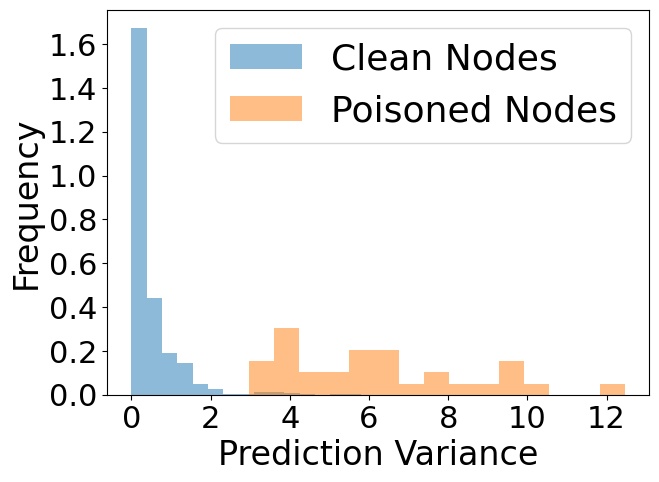

In [ ]:


# visualize robustness distribution #
a=torch.mean(summed_deviations,dim=-1)
a_excluding_last_40 = a[:-args.vs_number].detach().cpu()
a_last=a[-mask.sum():].detach().cpu()


a_last_40 = a[-args.vs_number:].detach().cpu()




indices_to_remove = [i for i, node in enumerate(known_nodes[-args.vs_number:]) if data.y[node] == args.target_class]

indices_to_remove = []

a_last_list = list(a_last)

indices_to_check = range(len(known_nodes[-args.vs_number:]))

# indices_to_remove = []

# ##### find those nodes that are already have target class or poisoned failed #####
# for i in indices_to_check:
#     condition1 = data.y[known_nodes[-args.vs_number:][i]] == args.target_class
#     condition2 = output.argmax(dim=1)[idx_attach[i]] != args.target_class
    
#     if condition1 or condition2:
#         indices_to_remove.append(i)

# for index in sorted(indices_to_remove, reverse=True):
#     del a_last_list[index]


a_last_40 = a_last_list
plt.figure(figsize=(7, 5))
# plt.figure(figsize=(40, 24))
##### benign nodes #####

plt.hist(a_excluding_last_40, bins=15, alpha=0.5, label='Clean Nodes', density=True)
plt.hist(a_last_40, bins=15, alpha=0.5, label='Poisoned Nodes',density=True)
##### poisoned success nodes #####

plt.legend(loc='upper right')
plt.xlabel('Prediction Variance',fontsize=24)
plt.ylabel('Frequency',fontsize=24)

from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x, pos: f'{x:.1f}')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.legend(fontsize=26)

plt.savefig('random_cora.pdf')
plt.show()

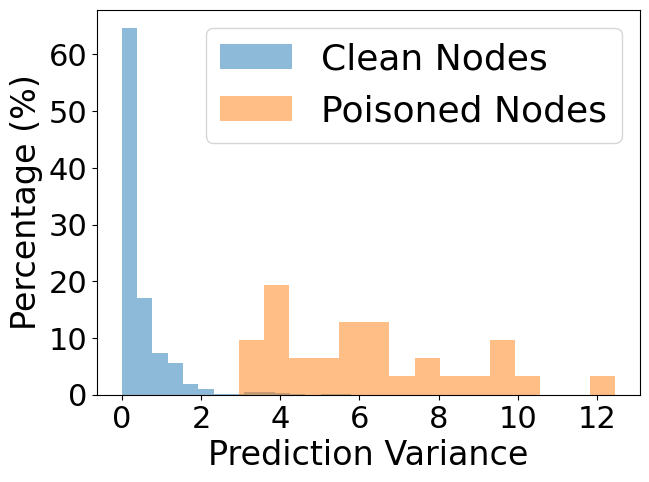

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Ensure a_excluding_last_40 is a numpy array
if not isinstance(a_excluding_last_40, np.ndarray):
    a_excluding_last_40 = a_excluding_last_40.detach().cpu().numpy()

# Ensure a_last_40 is a numpy array
if not isinstance(a_last_40, np.ndarray):
    a_last_40 = np.array(a_last_40)

# Calculate the histograms and convert them to percentages
bins = 15
hist_clean, bin_edges_clean = np.histogram(a_excluding_last_40, bins=bins, density=False)
hist_poisoned, bin_edges_poisoned = np.histogram(a_last_40, bins=bins, density=False)

# Calculate percentages
hist_clean_percentage = hist_clean / np.sum(hist_clean) * 100
hist_poisoned_percentage = hist_poisoned / np.sum(hist_poisoned) * 100

# Plot the histograms
plt.figure(figsize=(7, 5))

# Benign nodes
plt.hist(bin_edges_clean[:-1], bins=bin_edges_clean, weights=hist_clean_percentage, alpha=0.5, label='Clean Nodes', density=False)
# Poisoned nodes
plt.hist(bin_edges_poisoned[:-1], bins=bin_edges_poisoned, weights=hist_poisoned_percentage, alpha=0.5, label='Poisoned Nodes', density=False)

# Add legend, labels, and formatters
plt.legend(loc='upper right')
plt.xlabel('Prediction Variance', fontsize=24)
plt.ylabel('Percentage (%)', fontsize=24)

formatter = FuncFormatter(lambda x, pos: f'{x:.0f}')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(fontsize=26)
plt.savefig('random_cora_UGBA.pdf')
plt.show()

In [ ]:
print(max(a_excluding_last_40))
print(min(a_last_40))

5.798379
2.96276


In [ ]:
output_clean = torch.exp(output_clean)

In [ ]:
# output, x = test_model(poison_x,noisy_poison_edge_index,noisy_poison_edge_weights)
# output_clean = torch.exp(output)
# epsilon = 1e-8
print(output_clean[idx_attach].argmax(dim=1))


from torch_geometric.utils import k_hop_subgraph
result_clean=[]
for node_id in idx_train:
    node_id = node_id.item()
    subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
    loop_edges = edge_index[:, edge_index[0] == node_id]
    non_loop_edges = edge_index[:, edge_index[0] != node_id]

    selected_x = poison_x[subset]
    
    for i in range(loop_edges.size(1)):
        # Current loop edge to remove
        current_loop_edge = loop_edges[:, i]

        # Find indices of the current loop edge and its reverse
        forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
        reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

        # Combine masks for forward and reverse edges
        combined_mask = forward_edge_mask | reverse_edge_mask

        # Remove both forward and reverse edges from the graph
        modified_edge_index = edge_index[:, ~combined_mask]

        edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

        output = test_model(poison_x, modified_edge_index, edge_weights)
        output = output[node_id]
        output = torch.exp(output)
        output += epsilon
        # print(output)
        # print(output_clean[node_id])
        deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
        result_clean.append(deviation.mean().item())
        # print(deviation.mean().item())
print(result_clean)


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0], device='cuda:3')


/home/zbz5349/anaconda3/envs/spurious/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[0.0046961260959506035, 0.0010995417833328247, 0.010220406576991081, 0.00462912255898118, 0.018106218427419662, 0.0005601385491900146, 0.00033551003434695303, 0.0002431421889923513, 6.272095197346061e-05, 5.181659435038455e-05, 0.0024458011612296104, 0.0012544364435598254, 0.000585808593314141, 6.784845027141273e-05, 8.976273966254666e-05, 0.0003491963434498757, 0.0002162110758945346, 0.0004854970029555261, 0.00027099839644506574, 0.15134714543819427, 0.012841922231018543, 7.681881470489316e-06, 4.566541065287311e-06, 2.372644075876451e-06, 0.00018851931963581592, 4.433494723343756e-06, 0.00011452570470282808, 0.00028513799770735204, 0.00041412151767872274, 6.464954640250653e-05, 2.4984550691442564e-05, 0.00010426543303765357, 0.002796505345031619, 0.00020342128118500113, 0.0004209770413581282, 0.000272780132945627, 0.00047842509229667485, 0.00010608137381495908, 9.344565478386357e-05, 6.218387716216967e-05, 6.0094058426329866e-05, 1.2051646990585141e-05, 0.005620154086500406, 1.647443

In [ ]:
result_trigger = []
for node_id in idx_attach:
    node_id = node_id.item()
    subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
    loop_edges = edge_index[:, edge_index[0] == node_id]
    non_loop_edges = edge_index[:, edge_index[0] != node_id]

    selected_x = poison_x[subset]
    
    for i in range(loop_edges.size(1)):
        # Current loop edge to remove
        current_loop_edge = loop_edges[:, i]

        # Find indices of the current loop edge and its reverse
        forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
        reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

        # Combine masks for forward and reverse edges
        combined_mask = forward_edge_mask | reverse_edge_mask

        # Remove both forward and reverse edges from the graph
        modified_edge_index = edge_index[:, ~combined_mask]

        edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

        output = test_model(poison_x, modified_edge_index, edge_weights)
        output = output[node_id]
        output = torch.exp(output)
        output += epsilon
        # print(output)
        # print(output_clean[node_id])
        deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
        
        if loop_edges[:,i][1]>len(data.x):
            # print(loop_edges[:,i][1])
            result_trigger.append(deviation.mean().item())
            
        # else:
        # print(deviation.mean().item())
            # result_clean.append(deviation.mean().item())

        # result_trigger.append(deviation.mean().item())
        # print(deviation.mean().item())
print(result_trigger)

[0.686935305595398, 0.2520464062690735, 0.9102712273597717, 0.7195176482200623, 0.5371489524841309, 0.45379847288131714, 0.6800859570503235, 0.8619793653488159, 0.5454912781715393, 0.9496711492538452, 0.3140215575695038, 0.7677653431892395, 0.6564729809761047, 0.8722783327102661, 0.7717121243476868, 0.7789889574050903, 1.9745736122131348, 0.8992641568183899, 1.0468038320541382, 0.8305408954620361, 0.3746654689311981, 0.5902591943740845, 0.3326583802700043, 0.7392865419387817, 0.704847514629364, 0.5185059309005737, 0.48434194922447205, 0.603878915309906, 0.3425329327583313, 0.5085777640342712, 0.8669720888137817]


In [ ]:
len(result_trigger)

31

In [ ]:
output_clean[idx_attach].argmax(dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0], device='cuda:3')

In [ ]:
print(len(result_trigger))
print(min(result_trigger))
print(max(result_trigger))
print(sorted(result_trigger,reverse=True))
print(max(result_clean))
print(sorted(result_clean,reverse=True))

31
0.2520464062690735
1.9745736122131348
[1.9745736122131348, 1.0468038320541382, 0.9496711492538452, 0.9102712273597717, 0.8992641568183899, 0.8722783327102661, 0.8669720888137817, 0.8619793653488159, 0.8305408954620361, 0.7789889574050903, 0.7717121243476868, 0.7677653431892395, 0.7392865419387817, 0.7195176482200623, 0.704847514629364, 0.686935305595398, 0.6800859570503235, 0.6564729809761047, 0.603878915309906, 0.5902591943740845, 0.5454912781715393, 0.5371489524841309, 0.5185059309005737, 0.5085777640342712, 0.48434194922447205, 0.45379847288131714, 0.3746654689311981, 0.3425329327583313, 0.3326583802700043, 0.3140215575695038, 0.2520464062690735]
0.4697292447090149
[0.4697292447090149, 0.3886876404285431, 0.3672255873680115, 0.3650011420249939, 0.35542556643486023, 0.32586097717285156, 0.30628713965415955, 0.29585957527160645, 0.281095951795578, 0.26009601354599, 0.2462371289730072, 0.24061040580272675, 0.24019326269626617, 0.22754976153373718, 0.22325043380260468, 0.223199158906

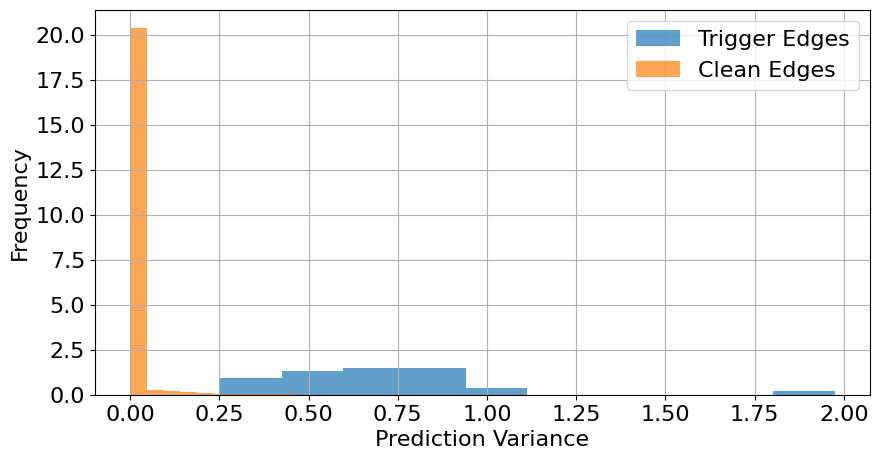

In [ ]:
import matplotlib.pyplot as plt

# Ensure you have your data loaded in result_clean and result_trigger
# Example: result_clean = [1, 2, 3], result_trigger = [3, 2, 1]
# result_trigger = [x for x in result_trigger if x < 0.8 and x>0.2]
# result_clean = [x for x in result_clean if x < 2 and x>0.2]

# plt.figure(figsize=(10, 5))

# plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Edge',density=True)
# # plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Data')

# plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Edge',density=True)
# # plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Data')


# # plt.title('Histogram of Clean and Trigger Data')
# plt.xlabel('Prediction Variance')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)

# # Save the plot before displaying it
# plt.savefig('cora.pdf')

# # Display the plot
# plt.show()
plt.figure(figsize=(10, 5))

plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Edges', density=True)
plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Edges', density=True)

plt.xlabel('Prediction Variance',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

# Adjust x and y ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)
plt.grid(True)

# Add a caption below the figure
# plt.figtext(0.5, -0.05, 'Comparison of prediction variance due to trigger edges drop and clean edges drop.', wrap=True, horizontalalignment='center', fontsize=14)

# Save the plot before displaying it
plt.savefig('cora.pdf')

# Display the plot
plt.show()

In [ ]:
filter = [x for x in result_clean if x > 0.4]
filter

[0.4697292447090149]

In [ ]:
poison_labels[idx_attach] = args.target_class

In [ ]:
## retrain a model on purified graph ##
# stop
# labels for target poisoned node before purified #
# print(poison_labels[idx_attach])

# # purifying #
# for idx in index_of_less_robust:
#     poison_labels[bkd_tn_nodes[idx]]=data.y[bkd_tn_nodes[idx]]

# # labels for target poisoned node after purified #
# print(poison_labels[idx_attach])

# # retrain a model #
# test_model = model_construct(args,args.test_model,data,device).to(device) 
# test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False)

# ## test model on purified graph (poisoned target node) ##
# clean_acc = test_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)

# print("accuracy on clean test nodes: {:.4f}".format(clean_acc))
print(poison_labels[idx_attach])

# purifying #
# for idx in index_of_less_robust[:400]:
#     poison_labels[bkd_tn_nodes[idx]]=data.y[bkd_tn_nodes[idx]]

# # labels for target poisoned node after purified #
# print(poison_labels[idx_attach])

# retrain a model #s
test_model = model_construct(args,args.test_model,data,device).to(device) 
test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False, finetune=True, attach=index_of_less_robust)

## test model on purified graph (poisoned target node) ##
clean_acc = test_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)

print("accuracy on clean test nodes: {:.4f}".format(clean_acc))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0], device='cuda:3')


/data/home/zbz5349/defense_backdoor/pre_test/models/SAGE.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx2 = torch.tensor(idx2).to(self.device)


accuracy on clean test nodes: 1.0000


In [ ]:
# add a trigger detector #
# assumption: backdoor attack's success is based on trigger pattern #
# 1. outlier, trigger different to each other #
# 2. in distribution, trigger similar to each other #
# in case, model trained on clean graph learn attack pattern #
induct_edge_index = torch.cat([poison_edge_index,mask_edge_index],dim=1)
induct_edge_weights = torch.cat([poison_edge_weights,torch.ones([mask_edge_index.shape[1]],dtype=torch.float,device=device)])
induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_atk,poison_x,induct_edge_index,induct_edge_weights,device)
induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()

output = test_model(induct_x,induct_edge_index,induct_edge_weights)
train_attach_rate = (output.argmax(dim=1)[idx_atk]==args.target_class).float().mean()
print("ASR: {:.4f}".format(train_attach_rate))
asr = train_attach_rate
flip_idx_atk = idx_atk[(data.y[idx_atk] != args.target_class).nonzero().flatten()]
flip_asr = (output.argmax(dim=1)[flip_idx_atk]==args.target_class).float().mean()
print("Flip ASR: {:.4f}/{} nodes".format(flip_asr,flip_idx_atk.shape[0]))
ca = test_model.test(induct_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
print("CA: {:.4f}".format(ca))

ASR: 0.9852
Flip ASR: 0.9822/225 nodes
CA: 0.7778


In [ ]:
predictions_1 = []
for i in range(4):
            test_model.eval()
            noisy_poison_edge_index, noisy_poison_edge_weights = sample_noise_all(poison_edge_index, poison_edge_weights, device)
            output = test_model(poison_x,noisy_poison_edge_index,noisy_poison_edge_weights)
            train_attach_rate = (output.argmax(dim=1)[idx_attach]==args.target_class).float().mean()
            train_clean_rate = (output.argmax(dim=1)[idx_train]==data.y[idx_train]).float().mean()
            predictions_1.append(torch.exp(output[known_nodes]))

epsilon = 1e-8
deviations = []
for sub_pred in predictions_1:

    sub_pred += epsilon
    deviation = F.kl_div(sub_pred.log(), ori_predict, reduce=False)
    for othersub_pred in predictions:
        deviation += F.kl_div(sub_pred.log(), othersub_pred, reduce=False)
    deviations.append(deviation)

/home/zbz5349/anaconda3/envs/spurious/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
summed_deviations = torch.zeros_like(deviations[0]).to(deviations[0].device)
for deviation in deviations:
    ##### summed deviations for each node #####
    summed_deviations += deviation


##### get the index for nodes with less robustness #####
    
##### args.vs_number is unknown #####
index_of_less_robust = torch.sort(torch.mean(summed_deviations,dim=-1),descending=True)[1][:mask.sum()]
print('index_of_less_robust',index_of_less_robust)

##### count how many poisoned target nodes are selected in less robustness nodes #####
count = 0
dd = []
for idx in index_of_less_robust:
    if idx >= len(known_nodes)-args.vs_number:
        count += 1
        dd.append(idx)
print('count',count)

index_of_less_robust tensor([557, 550, 556, 543, 555, 569, 562, 547, 553, 560, 548, 545, 546, 567,
        561, 565, 568, 564, 558, 544, 542, 549, 552, 559, 570, 571, 101, 541,
        302, 414,  54], device='cuda:3')
count 27


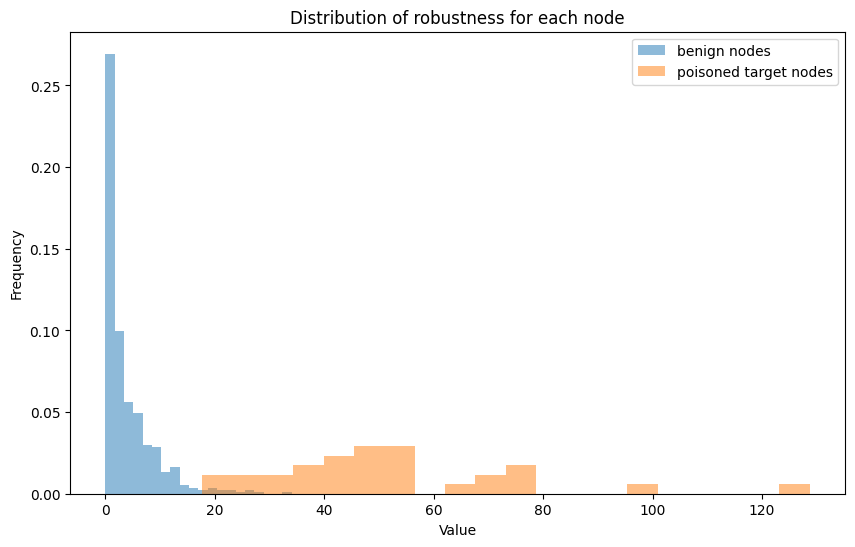

In [ ]:

# visualize robustness distribution #
a=torch.mean(summed_deviations,dim=-1)
a_excluding_last_40 = a[:-args.vs_number].detach().cpu()
a_last=a[-mask.sum():].detach().cpu()


a_last_40 = a[-args.vs_number:].detach().cpu()




indices_to_remove = [i for i, node in enumerate(known_nodes[-args.vs_number:]) if data.y[node] == args.target_class]

indices_to_remove = []

a_last_list = list(a_last)

indices_to_check = range(len(known_nodes[-args.vs_number:]))

# indices_to_remove = []

# ##### find those nodes that are already have target class or poisoned failed #####
# for i in indices_to_check:
#     condition1 = data.y[known_nodes[-args.vs_number:][i]] == args.target_class
#     condition2 = output.argmax(dim=1)[idx_attach[i]] != args.target_class
    
#     if condition1 or condition2:
#         indices_to_remove.append(i)

# for index in sorted(indices_to_remove, reverse=True):
#     del a_last_list[index]


a_last_40 = a_last_list
plt.figure(figsize=(10, 6))
# plt.figure(figsize=(40, 24))
##### benign nodes #####
plt.hist(a_excluding_last_40, bins=20, alpha=0.5, label='benign nodes', density=True)
##### poisoned success nodes #####
plt.hist(a_last_40, bins=20, alpha=0.5, label='poisoned target nodes',density=True)
plt.legend(loc='upper right')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of robustness for each node')
plt.savefig('a.jpg')
plt.show()

In [ ]:
test_model = model_construct(args,args.test_model,data,device).to(device) 
test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False)
test_model.eval()
clean_acc = test_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)
output_clean = test_model(poison_x,poison_edge_index,poison_edge_weights)
ori_predict = torch.exp(output_clean[known_nodes])
print("accuracy on poisoned target nodes: {:.4f}".format(clean_acc))


for i in range(10):
            test_model.eval()
            noisy_poison_edge_index, noisy_poison_edge_weights = sample_noise_all(poison_edge_index, poison_edge_weights, device)
            output = test_model(poison_x,noisy_poison_edge_index,noisy_poison_edge_weights)
            train_attach_rate = (output.argmax(dim=1)[idx_attach]==args.target_class).float().mean()
            train_clean_rate = (output.argmax(dim=1)[idx_train]==data.y[idx_train]).float().mean()
            predictions.append(torch.exp(output[known_nodes]))

epsilon = 1e-8
deviations = []
for sub_pred in predictions:
    sub_pred += epsilon
    deviation = F.kl_div(sub_pred.log(), ori_predict, reduce=False)
    deviations.append(deviation)

summed_deviations = torch.zeros_like(deviations[0]).to(deviations[0].device)
for deviation in deviations:
    ##### summed deviations for each node #####
    summed_deviations += deviation


##### get the index for nodes with less robustness #####
    
##### args.vs_number is unknown #####
# index_of_less_robust = torch.sort(torch.mean(summed_deviations,dim=-1),descending=True)[1][:mask.sum()]
index_of_less_robust = torch.sort(torch.mean(summed_deviations,dim=-1),descending=True)[1]

accuracy on poisoned target nodes: 1.0000


In [ ]:
def find_index(poison_labels, bkd_tn_nodes, index_of_less_robust, target_class):
    # Get the specific list to iterate through
    labels_list = poison_labels[bkd_tn_nodes[index_of_less_robust]]

    # Iterate through the list with index
    for i in range(len(labels_list) - 1):  # -1 to avoid index out of range
        if labels_list[i] != target_class and labels_list[i + 1] != target_class:
            return i - 1

    # Return None if the condition is not met in the loop
    return None

# Example usage:
# Assuming poison_labels, bkd_tn_nodes, index_of_less_robust, and target_class are defined
result_index = find_index(poison_labels, bkd_tn_nodes, index_of_less_robust, args.target_class)
print("Index found:", result_index)
print(poison_labels[bkd_tn_nodes[index_of_less_robust][:result_index]])

Index found: 25
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], device='cuda:3')


In [ ]:
## retrain a model on purified graph ##

# labels for target poisoned node before purified #
print(poison_labels[idx_attach])

# purifying #
# for idx in index_of_less_robust[:400]:
#     poison_labels[bkd_tn_nodes[idx]]=data.y[bkd_tn_nodes[idx]]

# # labels for target poisoned node after purified #
# print(poison_labels[idx_attach])

# retrain a model #s
test_model = model_construct(args,args.test_model,data,device).to(device) 

# test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False, finetune=True, attach=bkd_tn_nodes[index_of_less_robust][:result_index])
test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=400,verbose=False, finetune=True, attach=bkd_tn_nodes[index_of_less_robust][:result_index])
## test model on purified graph (poisoned target node) ##
clean_acc = test_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)

print("accuracy on clean test nodes: {:.4f}".format(clean_acc))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0], device='cuda:3')
accuracy on clean test nodes: 0.2258


In [ ]:
induct_edge_index = torch.cat([poison_edge_index,mask_edge_index],dim=1)
induct_edge_weights = torch.cat([poison_edge_weights,torch.ones([mask_edge_index.shape[1]],dtype=torch.float,device=device)])
induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_atk,poison_x,induct_edge_index,induct_edge_weights,device)
# induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_attach,poison_x,induct_edge_index,induct_edge_weights,device)
induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()

output = test_model(induct_x,induct_edge_index,induct_edge_weights)
train_attach_rate = (output.argmax(dim=1)[idx_atk]==args.target_class).float().mean()
# train_attach_rate = (output.argmax(dim=1)[idx_attach]==args.target_class).float().mean()
print("ASR: {:.4f}".format(train_attach_rate))
asr = train_attach_rate
flip_idx_atk = idx_atk[(data.y[idx_atk] != args.target_class).nonzero().flatten()]
flip_asr = (output.argmax(dim=1)[flip_idx_atk]==args.target_class).float().mean()
print("Flip ASR: {:.4f}/{} nodes".format(flip_asr,flip_idx_atk.shape[0]))
ca = test_model.test(induct_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
print("CA: {:.4f}".format(ca))

ASR: 0.2583
Flip ASR: 0.1600/225 nodes
CA: 0.8333


In [ ]:
indexs = poison_labels[bkd_tn_nodes[index_of_less_robust][:result_index]]
count = 0
for i in indexs:
    if i == args.target_class:
        count += 1
## correct
correct = count

## fasle
false = len(indexs) - count

print('recall', correct/mask.sum())
# print(false/mask.sum())
print('Accuracy', correct/len(indexs))

recall tensor(0.8065, device='cuda:3')
Accuracy 1.0


In [ ]:
def find_index(poison_labels, bkd_tn_nodes, index_of_less_robust, target_class):
    # Get the specific list to iterate through
    labels_list = poison_labels[bkd_tn_nodes[index_of_less_robust]]

    # Iterate through the list with index
    for i in range(len(labels_list) - 1):  # -1 to avoid index out of range
        if labels_list[i] != target_class and labels_list[i + 1] != target_class and labels_list[i+2]!=target_class:
            return i - 1

    # Return None if the condition is not met in the loop
    return None

# Example usage:
# Assuming poison_labels, bkd_tn_nodes, index_of_less_robust, and target_class are defined
result_index = find_index(poison_labels, bkd_tn_nodes, index_of_less_robust, args.target_class)
print("Index found:", result_index)

Index found: 48


In [ ]:
test_model = model_construct(args,args.test_model,data,device).to(device) 

# test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False, finetune=True, attach=bkd_tn_nodes[index_of_less_robust][:result_index])
test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=400,verbose=False, finetune=True, attach=bkd_tn_nodes[index_of_less_robust][:result_index-1])
## test model on purified graph (poisoned target node) ##
clean_acc = test_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)

print("accuracy on clean test nodes: {:.4f}".format(clean_acc))

# add a trigger detector #
# assumption: backdoor attack's success is based on trigger pattern #
# 1. outlier, trigger different to each other #
# 2. in distribution, trigger similar to each other #
# # in case, model trained on clean graph learn attack pattern #
induct_edge_index = torch.cat([poison_edge_index,mask_edge_index],dim=1)
induct_edge_weights = torch.cat([poison_edge_weights,torch.ones([mask_edge_index.shape[1]],dtype=torch.float,device=device)])
induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_atk,poison_x,induct_edge_index,induct_edge_weights,device)
# induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_attach,poison_x,induct_edge_index,induct_edge_weights,device)
induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()

output = test_model(induct_x,induct_edge_index,induct_edge_weights)
train_attach_rate = (output.argmax(dim=1)[idx_atk]==args.target_class).float().mean()
# train_attach_rate = (output.argmax(dim=1)[idx_attach]==args.target_class).float().mean()
print("ASR: {:.4f}".format(train_attach_rate))
asr = train_attach_rate
flip_idx_atk = idx_atk[(data.y[idx_atk] != args.target_class).nonzero().flatten()]
flip_asr = (output.argmax(dim=1)[flip_idx_atk]==args.target_class).float().mean()
print("Flip ASR: {:.4f}/{} nodes".format(flip_asr,flip_idx_atk.shape[0]))
ca = test_model.test(induct_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
print("CA: {:.4f}".format(ca))

accuracy on clean test nodes: 0.0000
ASR: 0.0332
Flip ASR: 0.0044/225 nodes
CA: 0.7963


In [ ]:
indexs = poison_labels[bkd_tn_nodes[index_of_less_robust][:result_index-1]]
count = 0
for i in indexs:
    if i == args.target_class:
        count += 1
## correct
correct = count

## fasle
false = len(indexs) - count

print('recall', correct/mask.sum())
# print(false/mask.sum())
print('Accuracy', correct/len(indexs))

recall tensor(1.3548, device='cuda:3')
Accuracy 0.8936170212765957
